In [1]:
import numpy as np
import os, glob
import matplotlib.pyplot as plt
import scipy
import mplhep as hep
import scipy.optimize as optimize
from scipy.stats import norm
from scipy.special import erf

plt.style.use([hep.style.ROOT, hep.style.firamath])
import pickle, glob
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
channel_list = ["Tracks_pt", "Tracks_dZSig", "Tracks_d0Sig", "ECAL_energy",
"HBHE_energy", "Pix_1", "Pix_2", "Pix_3", "Pix_4", "Tib_1", "Tib_2",
"Tib_3", "Tib_4", "Tob_1", "Tob_2", "Tob_3", "Tob_4", "Tob_5",
"Tob_6", "Tid_1", "Tec_1", "Tec_2", "Tec_3"]

from scipy.stats import norm
# Define the CMS color scheme
cms_colors = [
    (0.00, '#FFFFFF'),  # White
    (0.33, '#005EB8'),  # Blue
    (0.66, '#FFDD00'),  # Yellow
    (1.00, '#FF0000')   # red
]

# Create the CMS colormap
cms_cmap = LinearSegmentedColormap.from_list('CMS', cms_colors)

# out_dir='plots'
# if not os.path.isdir(out_dir):
#     os.makedirs(out_dir)
# save = True

In [2]:
parent_folder_path = '/global/cfs/cdirs/m4392/bbbam/mass_regression_models_for_validation_tests_using_data_v2/mass_trainer_aToTauTau_m1p2To17p2_v2_13ch/INFERENCE_DATA'

# Function for fitting signals

In [36]:

##---------------------------------------------------------------------------------
class AsymmetricGaussian:
    def __init__(self, mu, sigmaL, sigmaR, lambda_):
        self.mu = mu
        self.sigmaL = sigmaL
        self.sigmaR = sigmaR
        self.lambda_ = lambda_
    
    def __call__(self, x):
        z = (x - self.mu) / (self.sigmaL + self.sigmaR)
        pdf_value = (1 / (self.sigmaL + self.sigmaR)) * (
            norm.pdf(z) * norm.cdf(self.lambda_ * z)
        )
        return pdf_value
    
def nLLH_AG(params, data):
    mu, sigmaL, sigmaR, lambda_ = params
    pdf = AsymmetricGaussian(mu, sigmaL, sigmaR, lambda_)
    pdf_values = pdf(data)
    pdf_values = np.maximum(pdf_values, 1e-100)  # Avoid log(0)
    return -np.sum(np.log(pdf_values))

def nLLH_AG_calculation(m_pred_):
    initial_guess = [10, 1.0, 1.0, 1.0]
    # Minimize the negative log-likelihood
    result=optimize.minimize(lambda params: nLLH_AG(params, m_pred_),initial_guess, method='L-BFGS-B')
    # Extract the fitted parameters
    fitted_params = result.x
    fitted_pdf = AsymmetricGaussian(*fitted_params)
    print('FITTED PARAMETER', fitted_params)
    return fitted_pdf

##---------------------------------------------------------------------------------
class GaussianModified:
    def __init__(self, k, x0, sig, a):
        self.k = k      # Amplitude factor
        self.x0 = x0    # Mean of the Gaussian
        self.sig = sig  # Standard deviation of the Gaussian
        self.a = a      # Parameter for the error function

    def __call__(self, x):
        # Compute the Gaussian term
        gaussian_term = np.exp(-((x - self.x0) ** 2) / (2 * self.sig ** 2))
        # Compute the error function term
        erf_term = 1 + erf((self.a * (x - self.x0)) / (self.sig * np.sqrt(2)))
        # Combine them
        return self.k * gaussian_term * erf_term
    
def nLLH_GM(params, data):
    k, x0, sig, a = params
    pdf = GaussianModified(k, x0, sig, a)
    pdf_values = pdf(data)
    pdf_values = np.maximum(pdf_values, 1e-100)  # Avoid log(0)
    return -np.sum(np.log(pdf_values))

def nLLH_GM_calculation(m_pred_):
    initial_guess = [mass, 1.0, 1.0, 1.0]
    # Minimize the negative log-likelihood
    result=optimize.minimize(lambda params: nLLH_GM(params, m_pred_),initial_guess, method='L-BFGS-B')
    # Extract the fitted parameters
    fitted_params = result.x
    print('FITTED PARAMETER', fitted_params)
    fitted_pdf = GaussianModified(*fitted_params)
    return fitted_pdf
##---------------------------------------------------------------------------------
class gaussian_peak:
    def __init__(self, a, m0, sig):
        self.a = a  # amplitude of the Gaussian
        self.m0 = m0  # mean of gaussian
        self.sig = sig  # Standard deviation of the Gaussian
    def __call__(self, x):
         return self.a * np.exp(-((x - self.m0)**2) / (2 * self.sig**2))

        
def nLLH_GP(params, data):
    a, m0, sig = params
    pdf = gaussian_peak(a, m0, sig)
    pdf_values = pdf(data)
    pdf_values = np.maximum(pdf_values, 1e-100)  # Avoid log(0)
    return -np.sum(np.log(pdf_values))
def nLLH_GP_calculation(m_pred_):
    initial_guess = [10, 10, 10]
    # Minimize the negative log-likelihood
    result=optimize.minimize(lambda params: nLLH_GP(params, m_pred_),initial_guess, method='L-BFGS-B')
    # Extract the fitted parameters
    fitted_params = result.x
    fitted_pdf = gaussian_peak(*fitted_params)
    print('FITTED PARAMETER', fitted_params)
    return fitted_pdf
##---------------------------------------------------------------------------------



class CruijffPdf:
    def __init__(self, m0, sigmaL, sigmaR, alphaL, alphaR, amplitude):
        self.m0 = m0
        self.sigmaL = sigmaL
        self.sigmaR = sigmaR
        self.alphaL = alphaL
        self.alphaR = alphaR
        self.amplitude = amplitude
    
    def __call__(self, m):
        dx = m - self.m0
        sigma = np.where(dx < 0, self.sigmaL, self.sigmaR)
        alpha = np.where(dx < 0, self.alphaL, self.alphaR)
        f = 2 * sigma**2 + alpha * dx**2
        return self.amplitude*np.exp(-dx**2/f) 

def nLLH_CF(params, data):
    m0, sigmaL, sigmaR, alphaL, alphaR, amp = params
    pdf = CruijffPdf(m0, sigmaL, sigmaR, alphaL, alphaR, amp)
    pdf_values = pdf(data)
    pdf_values = np.maximum(pdf_values, 1e-100)  # Avoid log(0)
    return -np.sum(np.log(pdf_values))

def nLLH_CF_calculation(m_pred_):
    initial_guess = [10, 1.0, 1.0, 1.5, 1.5,0.5]
    # Minimize the negative log-likelihood
    result=optimize.minimize(lambda params: nLLH_CF(params, m_pred_),initial_guess, method='L-BFGS-B')
    fitted_params = result.x
    print('FITTED PARAMETER', fitted_params)
    fitted_pdf = CruijffPdf(*fitted_params)
    return fitted_pdf
##---------------------------------------------------------------------------------

class GaussianPdf:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
    
    def __call__(self, x):
        return (1 / (self.sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - self.mu) / self.sigma)**2)

def nLLH_G(params, data):
    mu, sigma = params
    pdf = GaussianPdf(mu, sigma)
    pdf_values = pdf(data)
    pdf_values = np.maximum(pdf_values, 1e-100)  # Avoid log(0)
    return -np.sum(np.log(pdf_values))

def nLLH_G_calculation(m_pred_):
    initial_guess = [10, 1.0]
    # Minimize the negative log-likelihood
    result=optimize.minimize(lambda params: nLLH_G(params, m_pred_),initial_guess, method='L-BFGS-B')
    # Extract the fitted parameters
    fitted_params = result.x
    print('FITTED PARAMETER', fitted_params)
    fitted_pdf = GaussianPdf(*fitted_params)
    return fitted_pdf

###----------------------------------------------------------------------------------------------------------------------------------------------------


class BreitWignerPdf:
    def __init__(self, E0, Gamma):
        self.E0 = E0  # Resonance energy
        self.Gamma = Gamma  # Width of the resonance
    
    def __call__(self, E):
        # Relativistic Breit-Wigner formula
        numerator = self.E0 * self.Gamma
        denominator = (E**2 - self.E0**2)**2 + (self.E0 * self.Gamma)**2
        return numerator / denominator

def nLLH_BW(params, data):
    E0, Gamma = params
    pdf = BreitWignerPdf(E0, Gamma)
    pdf_values = pdf(data)
    pdf_values = np.maximum(pdf_values, 1e-100)  # Avoid log(0)
    return -np.sum(np.log(pdf_values))

def nLLH_BW_calculation(m_pred_):
    initial_guess = [10, 1.0]  # Initial guess for E0 and Gamma
    # Minimize the negative log-likelihood
    result = optimize.minimize(lambda params: nLLH_BW(params, m_pred_), initial_guess, method='L-BFGS-B')
    # Extract the fitted parameters
    fitted_params = result.x
    print('FITTED PARAMETERS:', fitted_params)
    fitted_pdf = BreitWignerPdf(*fitted_params)
    return fitted_pdf
###-------------------------------------------------------------------------------------------------------------------------------------------------------


class CrystalBallPdf:
    def __init__(self, alpha, n, mean, sigma):
        self.alpha = alpha
        self.n = n
        self.mean = mean
        self.sigma = sigma
        
        self.A = (n / abs(alpha))**n * np.exp(-0.5 * alpha**2)
        self.B = n / abs(alpha) - abs(alpha)
        self.C = n / abs(alpha) * (1 / (n - 1)) * np.exp(-0.5 * alpha**2)
        self.D = np.sqrt(np.pi / 2) * (1 + scipy.special.erf(abs(alpha) / np.sqrt(2)))

    def __call__(self, x):
        t = (x - self.mean) / self.sigma
        if t > -self.alpha:
            return np.exp(-0.5 * t**2)
        else:
            return self.A * (self.B - t)**(-self.n)

def nLLH_CB(params, data):
    alpha, n, mean, sigma = params
    pdf = CrystalBallPdf(alpha, n, mean, sigma)
    pdf_values = np.array([pdf(x) for x in data])
    pdf_values = np.maximum(pdf_values, 1e-100)  # Avoid log(0)
    return -np.sum(np.log(pdf_values))

def nLLH_CB_calculation(m_pred_):
    initial_guess = [1.0, 2.0, np.mean(m_pred_), np.std(m_pred_)]  # Initial guess for alpha, n, mean, sigma
    # Minimize the negative log-likelihood
    result = optimize.minimize(lambda params: nLLH_CB(params, m_pred_), initial_guess, method='L-BFGS-B')
    # Extract the fitted parameters
    fitted_params = result.x
    print('FITTED PARAMETERS:', fitted_params)
    fitted_pdf = CrystalBallPdf(*fitted_params)
    return fitted_pdf



## Check the shape of functions

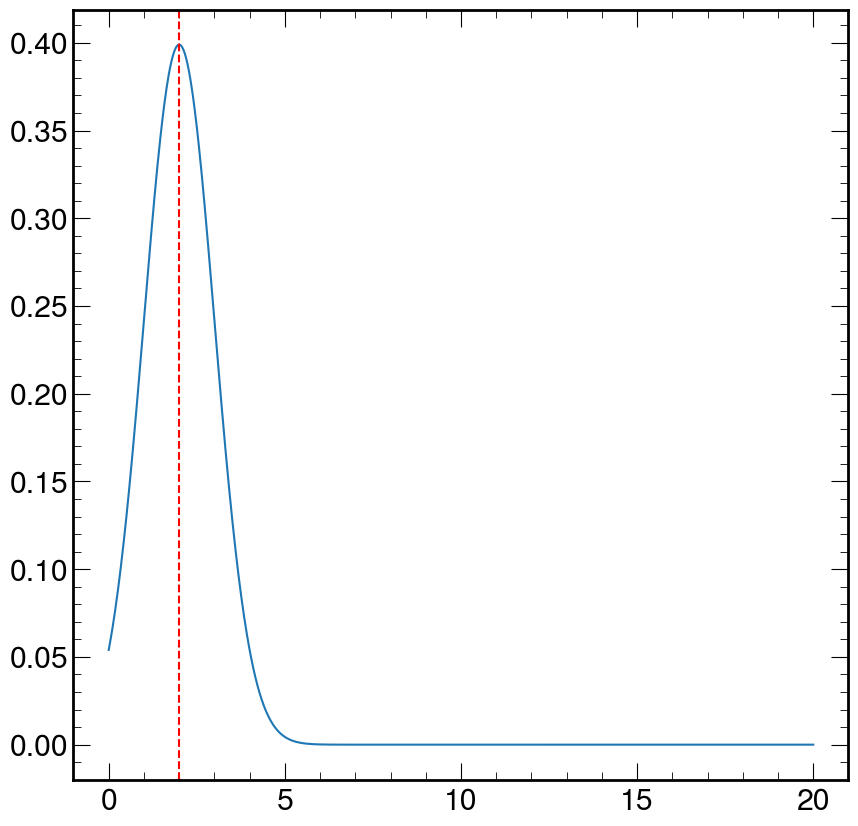

In [7]:
x = np.linspace(0,20,1000)
# x= m_pred_
##--------------------Gaussian---------------------------------

fitted_params = [2, 1]
fitted_pdf = GaussianPdf(*fitted_params)

##---------------------Cruijff--------------------------------

# fitted_params = [5, 0.6, 0.8, 1, 1, 1]
# fitted_pdf =  CruijffPdf(*fitted_params)

##--------------------AsymmetricGaussian---------------------------

# fitted_params = [10, 2.0, 2.0, -1]
# fitted_pdf = AsymmetricGaussian(*fitted_params)

##--------------------gaussian_peak---------------------------

# fitted_params = [10, 1.0, 1.0]
# fitted_pdf = fitted_pdf = gaussian_peak(*fitted_params)

##--------------------GaussianModified---------------------------
# fitted_params = [10, 10, 4.0, 3.0]
# fitted_pdf = fitted_pdf = GaussianModified(*fitted_params)

##--------------------BreitWignerPdf---------------------------

# fitted_params = [5.0, 2]
# fitted_pdf = fitted_pdf = BreitWignerPdf(*fitted_params)


##--------------------CrystalBallPdf---------------------------

# fitted_params = [1, 2, 5, 2]
# fitted_pdf = CrystalBallPdf(*fitted_params)

###------------------------------------------------------------------------------------------
y = fitted_pdf(x)
plt.plot(x,y)
plt.axvline(x=fitted_params[0],linestyle="--", color='r')

# plt.hist(np.array(m_pred_).flatten(),range=(0,m0_max+1.2), bins=len(np.arange(0,m0_max+1.2,bin_size)), density=True, histtype='step',  linestyle='-', color='b', linewidth=2, label='E2E prediction')

### Fit to prediction

for mass:   4
FITTED PARAMETERS: [5.55793187 1.84067288]


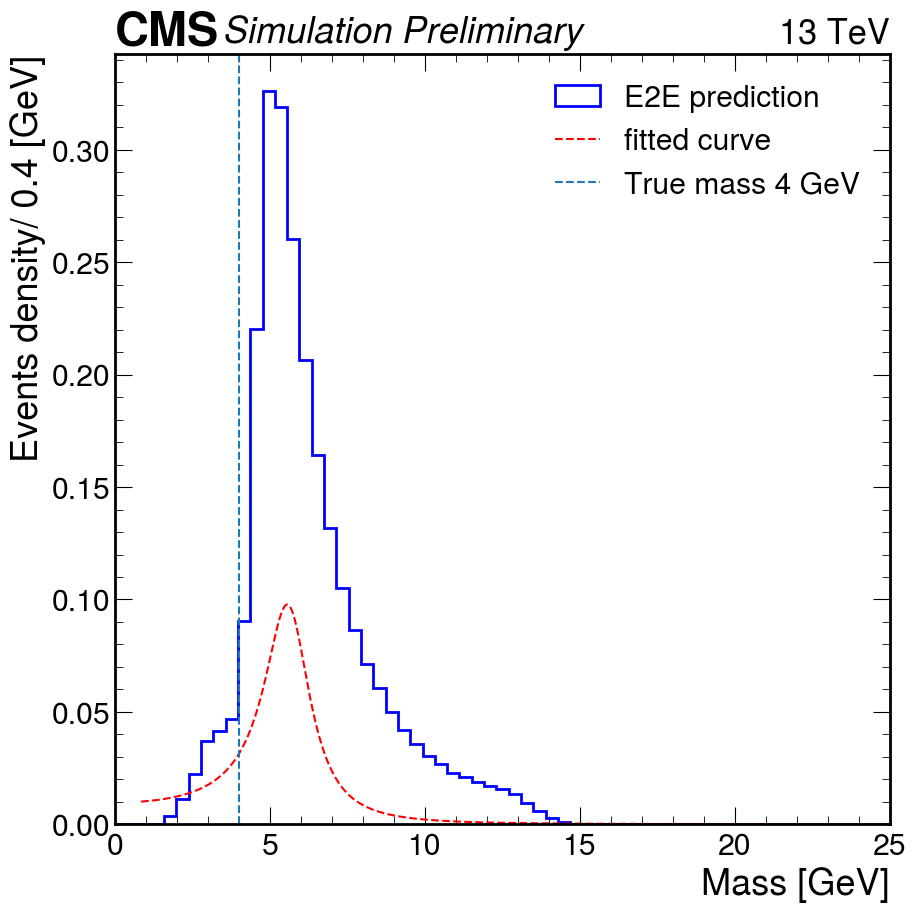

In [29]:
Mass = '4'
mass  = {'3p7':3.7,'4':4, '5':5, '6':6, '8':8, '10':10, '12':12, '14':14}.get(Mass, None)
print('for mass:  ', mass)
paths=np.sort(glob.glob(f'{parent_folder_path}/INFERENCE_13_channels_aToTauTau_m1p2To17p2_pT30To180_M_{Mass}_H_AA_4Tau/epoch10_val_pseudoscala*.pkl'))
assert len(paths) > 0


m0_min = 0
m0_max = 25
bin_size = 0.4

infile = open(f"{paths[0]}", "rb")
data = pickle.load(infile)
infile.close()
m_pred_ = data["m_pred"]

x = np.linspace(min(m_pred_), max(m_pred_),10000)
fitted_pdf = nLLH_BW_calculation(m_pred_)
y = fitted_pdf(x)


fig, ax = plt.subplots()
plt.hist(np.array(m_pred_).flatten(),range=(0,m0_max+1.2), bins=len(np.arange(0,m0_max+1.2,bin_size)), density=True, histtype='step',  linestyle='-', color='b', linewidth=2, label='E2E prediction')
# plt.show()
plt.plot(x, y,linestyle='--', color='red',label=f'fitted curve')
plt.axvline(x= mass,linestyle='--',label=f'True mass {Mass} GeV')
plt.xlim(0,25)
plt.xlabel('Mass [GeV]')
plt.ylabel('Events density/ 0.4 [GeV]')
plt.legend(loc='best')
hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
plt.show() 


### Fitting central bins only

for mass:   4
central bin   4.800000000000002
[2.8 3.2 3.6 4.  4.4 4.8 5.2 5.6 6.  6.4 6.8 7.2]
FITTED PARAMETER [5.38666302 0.92218781]


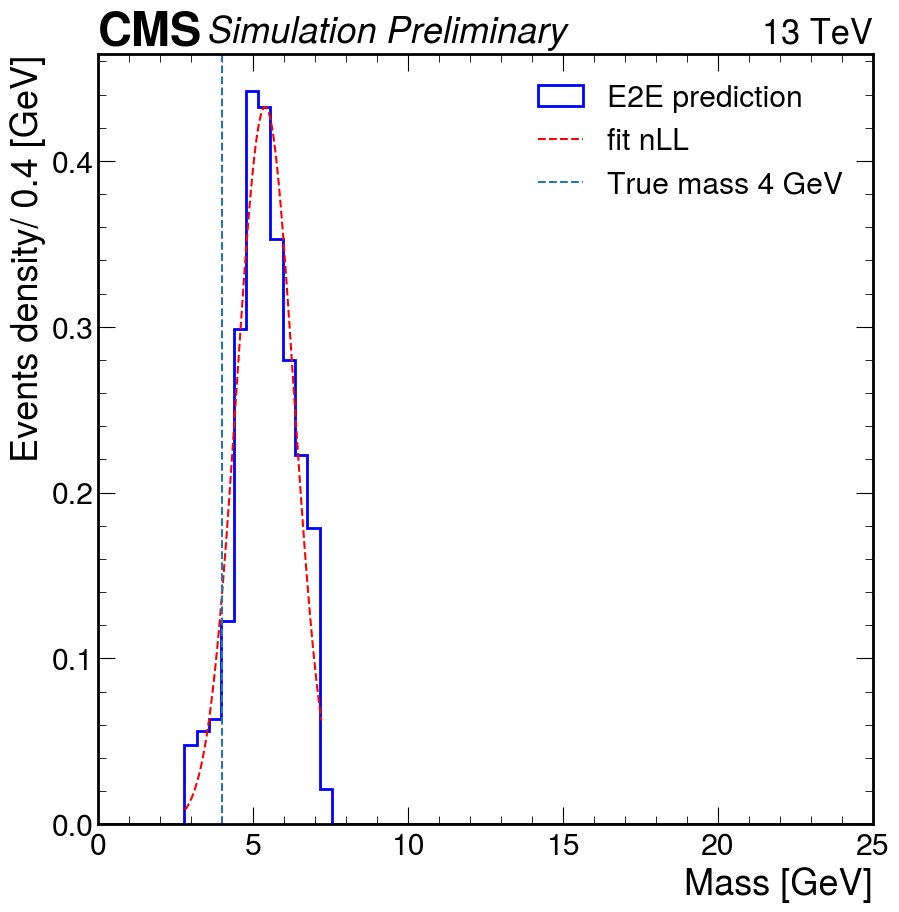

In [22]:
Mass = '4'
mass  = {'3p7':3.7,'4':4, '5':5, '6':6, '8':8, '10':10, '12':12, '14':14}.get(Mass, None)
print('for mass:  ', mass)
paths=np.sort(glob.glob(f'{parent_folder_path}/INFERENCE_13_channels_aToTauTau_m1p2To17p2_pT30To180_M_{Mass}_H_AA_4Tau/epoch10_val_pseudoscala*.pkl'))
assert len(paths) > 0


m0_min = 0
m0_max = 25
bin_size = 0.4

infile = open(f"{paths[0]}", "rb")
data = pickle.load(infile)
infile.close()
m_pred_ = data["m_pred"]


#------------below for fitting central bins only--------------------------------------------------------
    
def get_central_bins(data, lower_mass=1.2, upper_mass=17.2, bin_size=0.4, number_bins=6):
    bins=np.arange(lower_mass, upper_mass+bin_size, bin_size)
    counts, bin_edges = np.histogram(data, bins=bins)

    # Find the index of the mode bin
    mode_bin_index = np.argmax(counts)
    print("central bin  ", bins[mode_bin_index])
    start_bin_index = max(0, abs(mode_bin_index-number_bins))
    end_bin_index = min(mode_bin_index+number_bins, len(bins)-1)
    central_bins = np.arange(bins[start_bin_index], bins[end_bin_index]+bin_size, bin_size)
    print(central_bins)
    return central_bins 

central_bins = get_central_bins(m_pred_, lower_mass=1.2, upper_mass=17.2, bin_size=0.4, number_bins=5)
mask = (m_pred_ >= central_bins[0]) & (m_pred_ < central_bins[-1])

m_pred_ = m_pred_[mask]

#------------above this for fitting central bins only---------------------------------------------------



x = np.linspace(min(m_pred_), max(m_pred_),10000)
fitted_pdf = nLLH_G_calculation(m_pred_)
y = fitted_pdf(x)

# mu, std = norm.fit(m_pred_)
# print(mu, std)
# # mu, std = 5, 0.75
# y = norm.pdf(x, mu, std)


fig, ax = plt.subplots()
plt.hist(np.array(m_pred_).flatten(),range=(0,m0_max+1.2), bins=len(np.arange(0,m0_max+1.2,bin_size)), density=True, histtype='step',  linestyle='-', color='b', linewidth=2, label='E2E prediction')
# plt.show()
plt.plot(x, y,linestyle='--', color='red',label=f'fit nLL')
plt.axvline(x= mass,linestyle='--',label=f'True mass {Mass} GeV')
plt.xlim(0,25)
plt.xlabel('Mass [GeV]')
plt.ylabel('Events density/ 0.4 [GeV]')
plt.legend(loc='best')
hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
plt.show() 


# --------------- Fitting  on signals ------------------

In [27]:
def fit_signal(Mass='4'):
    mass  = {'3p7':3.7,'4':4, '5':5, '6':6, '8':8, '10':10, '12':12, '14':14}.get(Mass, None)
    print('for mass:  ', mass)
    paths=np.sort(glob.glob(f'{parent_folder_path}/INFERENCE_13_channels_aToTauTau_m1p2To17p2_pT30To180_M_{Mass}_H_AA_4Tau/epoch10_val_pseudoscala*.pkl'))
    assert len(paths) > 0


    m0_min = 0
    m0_max = 25
    bin_size = 0.4

    infile = open(f"{paths[0]}", "rb")
    data = pickle.load(infile)
    infile.close()
    m_pred_ = data["m_pred"]
    
    #------------below for fitting central bins only--------------------------------------------------------
    
    def get_central_bins(data, lower_mass=1.2, upper_mass=17.2, bin_size=0.4, number_bins=6):
        bins=np.arange(lower_mass, upper_mass+bin_size, bin_size)
        counts, bin_edges = np.histogram(data, bins=bins)

        # Find the index of the mode bin
        mode_bin_index = np.argmax(counts)
        start_bin_index = max(0, abs(mode_bin_index-number_bins))
        end_bin_index = min(mode_bin_index+number_bins, len(bins)-1)
        central_bins = np.arange(bins[start_bin_index], bins[end_bin_index]+bin_size, bin_size)
        return central_bins 

    central_bins = get_central_bins(m_pred_, lower_mass=1.2, upper_mass=17.2, bin_size=0.4, number_bins=6)
    mask = (m_pred_ >= central_bins[0]) & (m_pred_ < central_bins[-1])

    m_pred_ = m_pred_[mask]
    
    #------------above this for fitting central bins only---------------------------------------------------

    
    x = np.linspace(min(m_pred_), max(m_pred_),10000)


    fitted_pdf = nLLH_G_calculation(m_pred_)
    y = fitted_pdf(x)

    # mu, std = norm.fit(m_pred_)
    # y1 = norm.pdf(x, mu, std)


    fig, ax = plt.subplots()
    plt.hist(np.array(m_pred_).flatten(),range=(0,m0_max+1.2), bins=len(np.arange(0,m0_max+1.2,bin_size)), density=True, histtype='step',  linestyle='-', color='b', linewidth=2, label='E2E prediction')
    plt.plot(x, y,linestyle='--', color='red',label=f'fit nLL')
    plt.axvline(x= mass,linestyle='--',label=f'True mass {Mass} GeV')
    plt.xlim(0,25)
    plt.xlabel('Mass [GeV]')
    plt.ylabel('Events density/ 0.4 [GeV]')
    plt.legend(loc='best')
    hep.cms.label(llabel="Simulation Preliminary", rlabel="13 TeV", loc=0, ax=ax)
    plt.show() 

for mass:   3.7
FITTED PARAMETER [5.30133934 1.08352976]


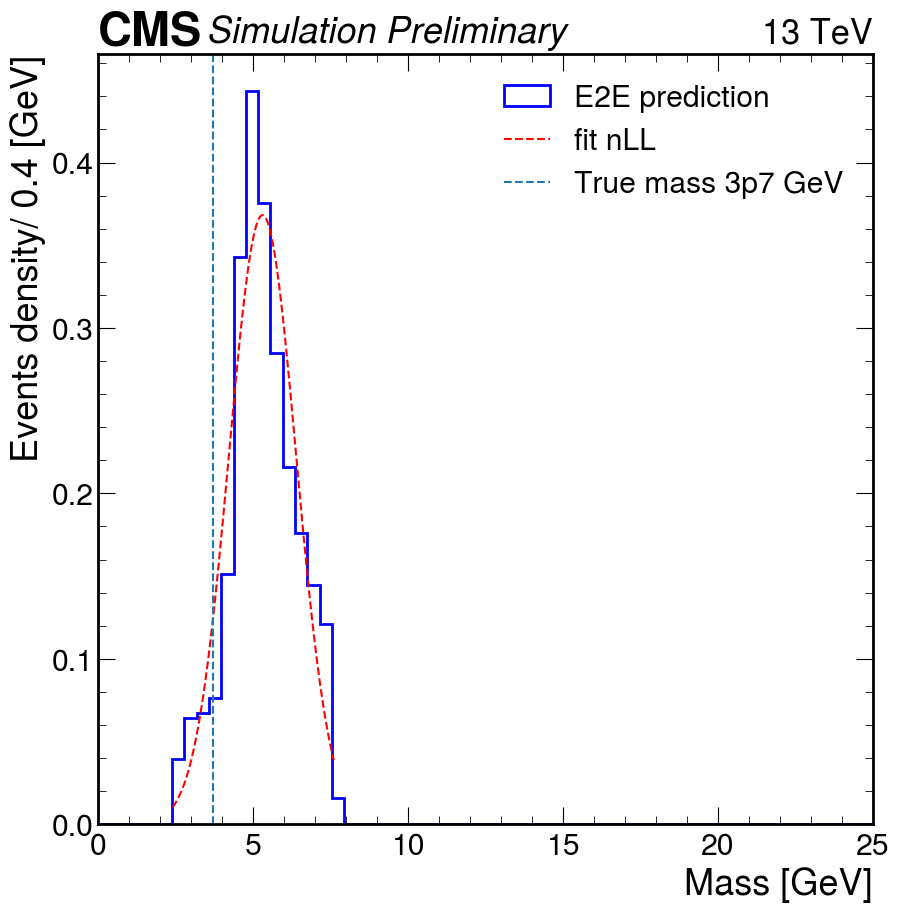

for mass:   4
FITTED PARAMETER [5.45802539 1.04454602]


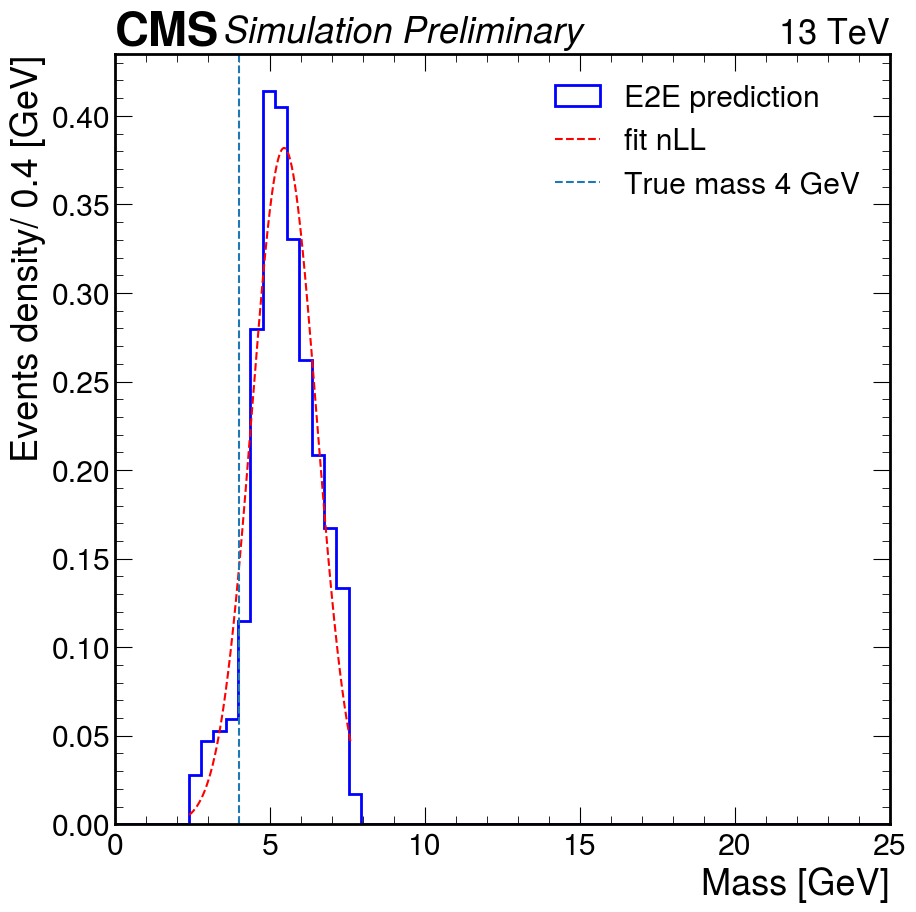

for mass:   5
FITTED PARAMETER [6.24129599 1.09955344]


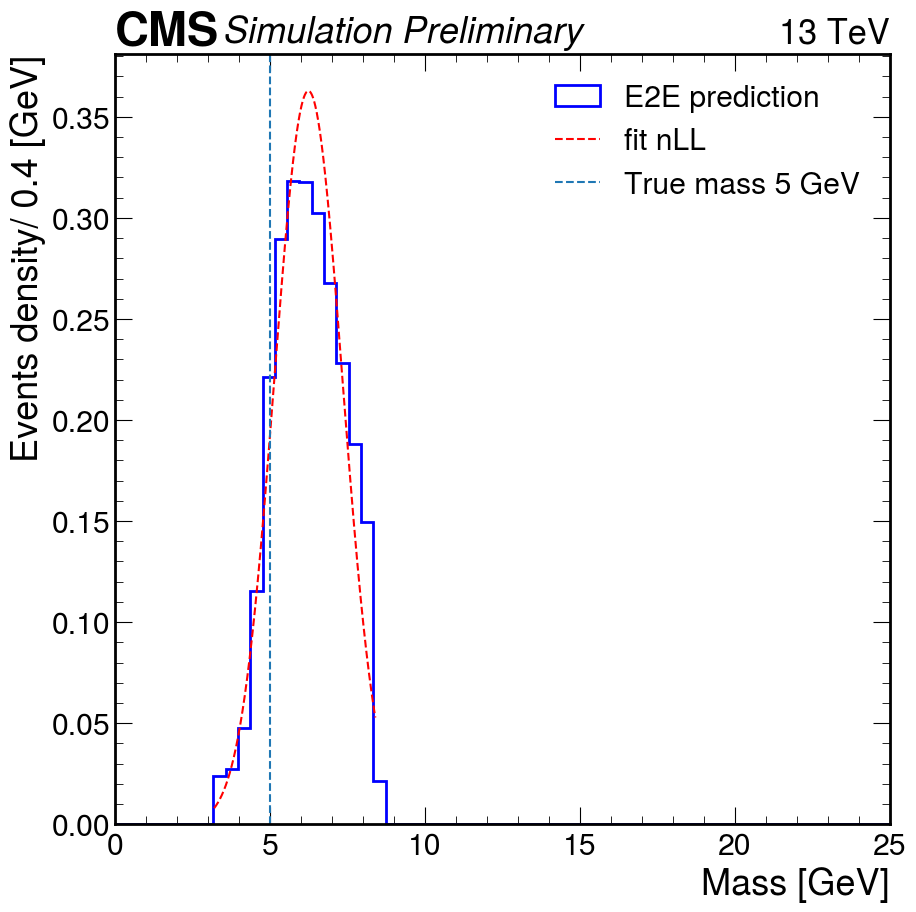

for mass:   6
FITTED PARAMETER [7.19735556 1.25119313]


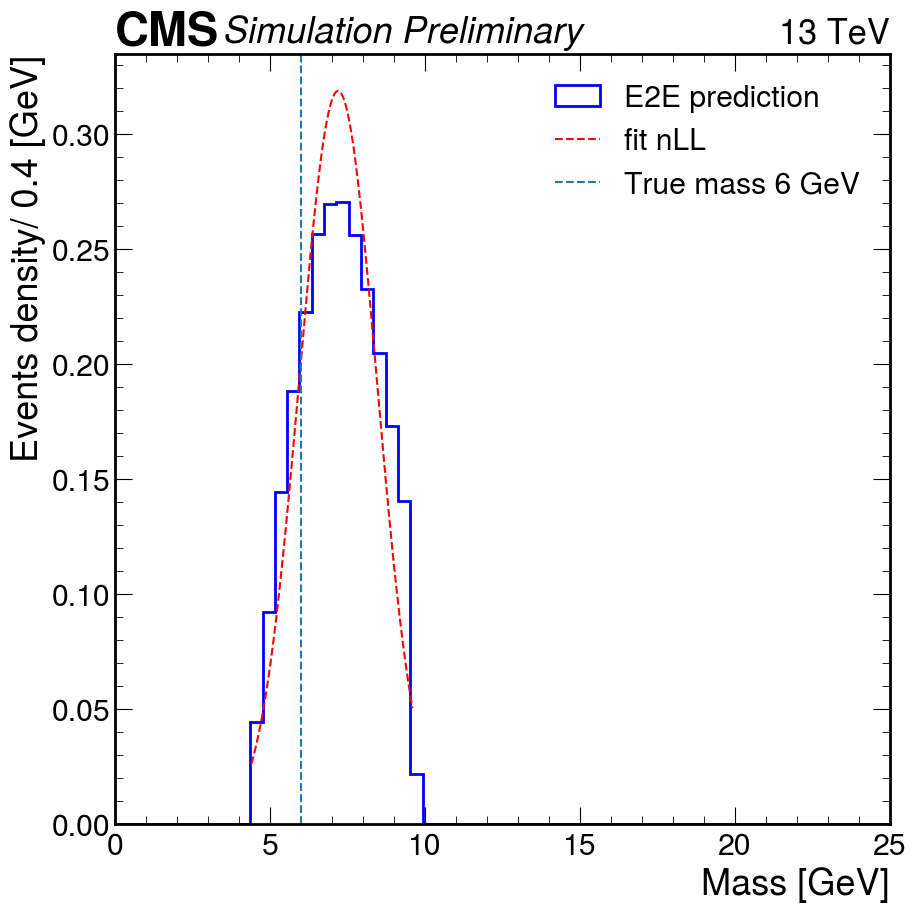

for mass:   8
FITTED PARAMETER [9.37368154 1.37193558]


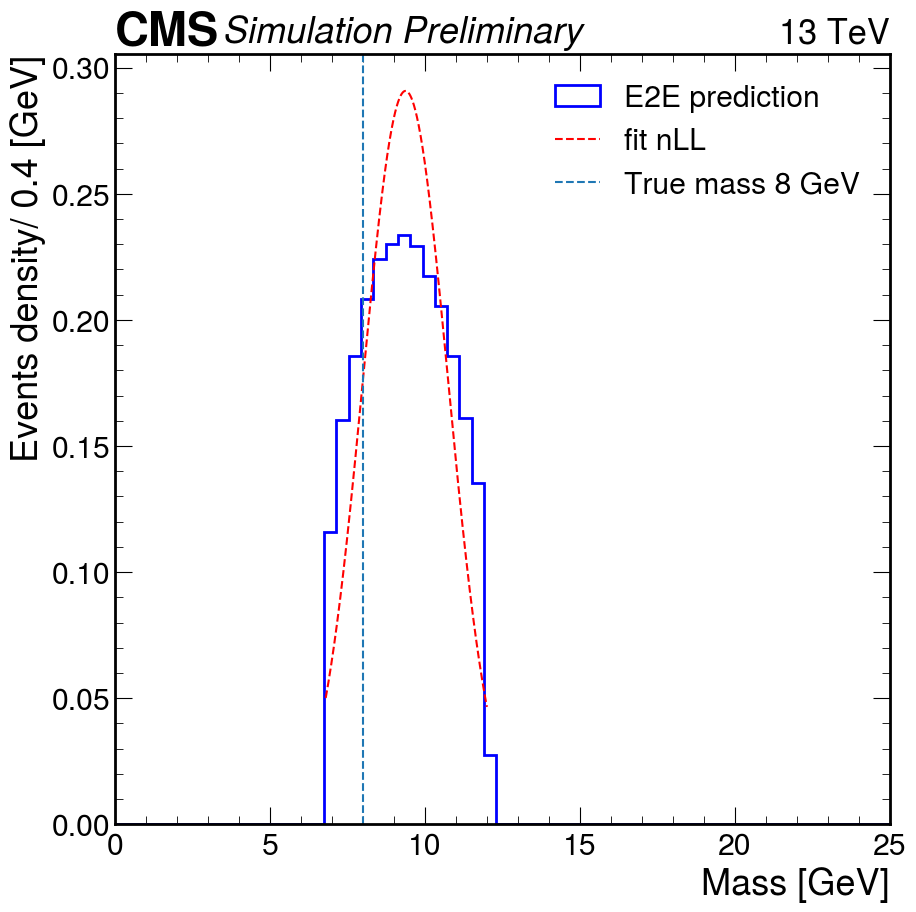

for mass:   10
FITTED PARAMETER [11.82028206  1.2933182 ]


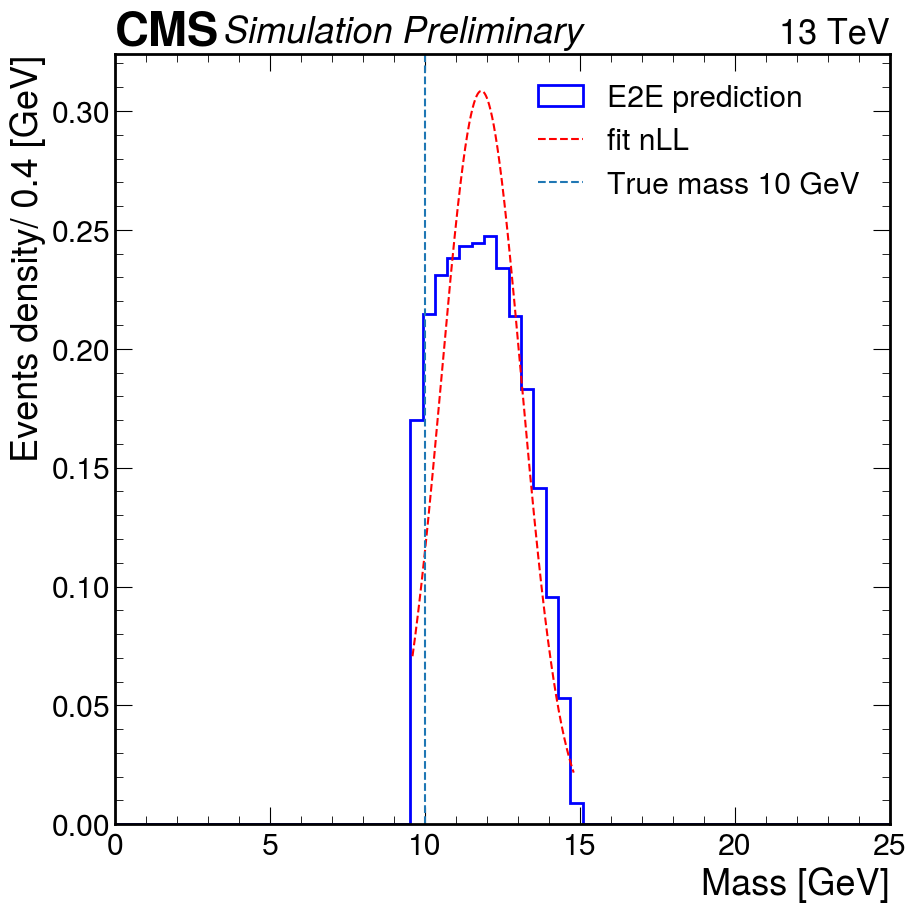

for mass:   12
FITTED PARAMETER [12.62289574  1.23703156]


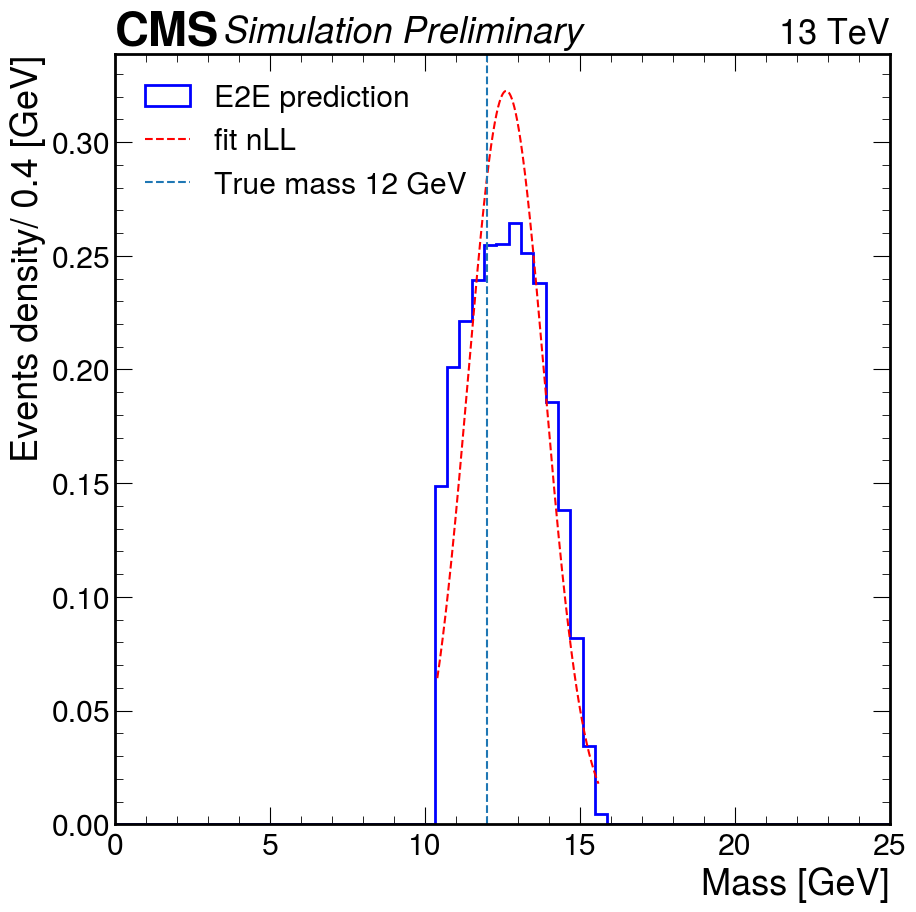

for mass:   14
FITTED PARAMETER [13.35969707  1.272954  ]


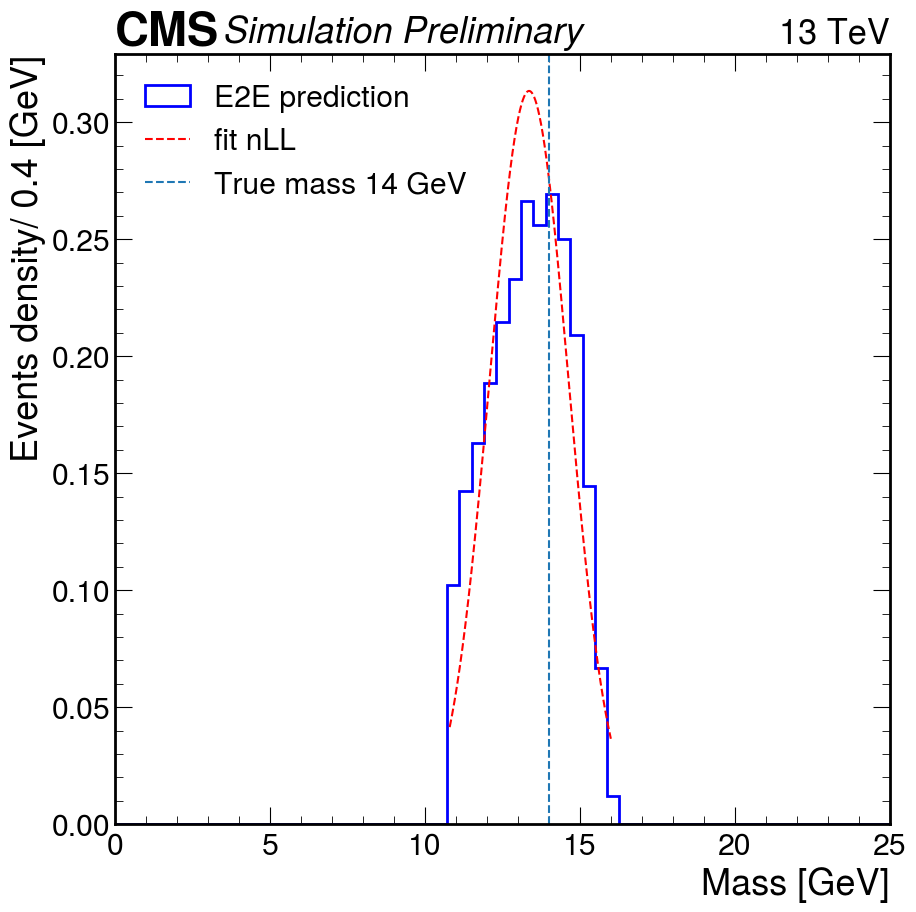

In [28]:
Masses  = ['3p7', '4', '5', '6', '8', '10', '12', '14']
for Mass in Masses:
    fit_signal(Mass)
    

### finding standard devition for skewed data

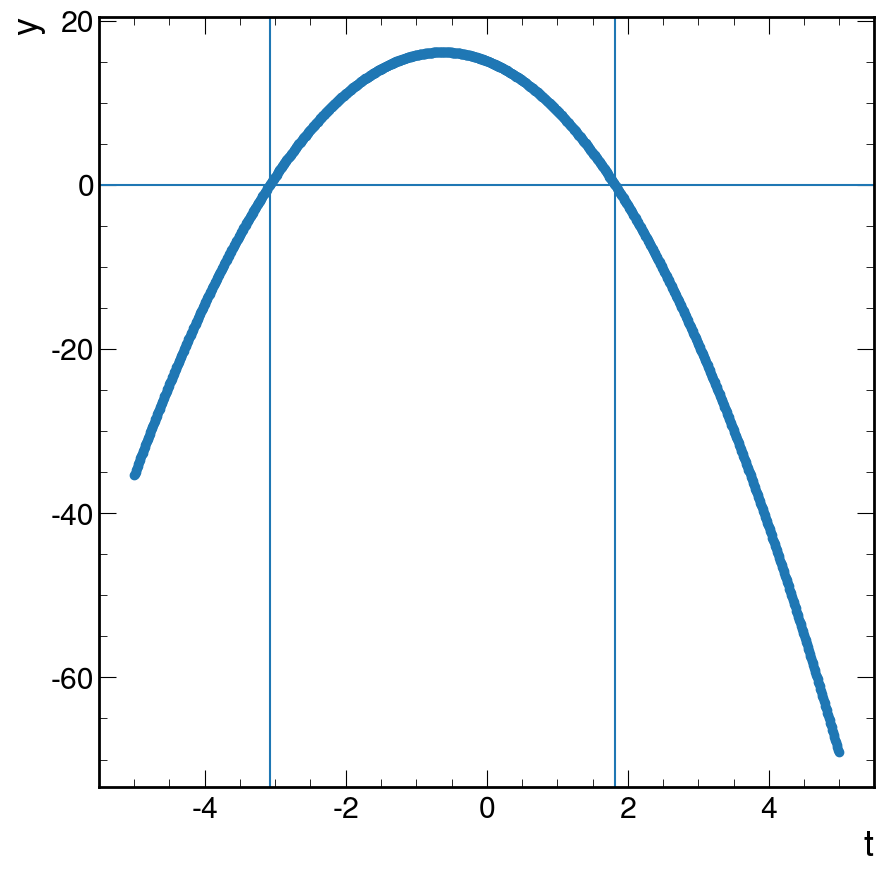

second root from brentq is  -3.0768783017306354  root from quadratic function is  -3.076878301730636
second root from brentq is  1.817619042471367  root from quadratic function is  1.8176190424713763


In [30]:
# Brentq example: find the root of a parabola, compare to the expected value from the quadratic formula.

a = -2.7
b = -3.4
c = 15.1

def myquad(A,B,C):
    return [(-B + np.sqrt(B**2 - 4*A*C))/(2*A),(-B - np.sqrt(B**2 - 4*A*C))/(2*A)]

def myparabola(A,B,C,t):
    return A*t**2 + B*t + C

quadroots = myquad(a,b,c)

ti = np.arange(-5,5,0.01) 
y = myparabola(a,b,c,ti)

# The following code finds the root of the parabola in two different ranges, -4 to 0 and 0 to 4. These should
# correspond to the first and second roots from the quadratic function.
root1 = optimize.brentq(lambda t: myparabola(a,b,c,t),-4,0)
root2 = optimize.brentq(lambda t: myparabola(a,b,c,t),0,4)

plt.clf()
plt.scatter(ti,y)
plt.axhline(0)
plt.axvline(quadroots[0])
plt.axvline(quadroots[1])
plt.xlabel('t')
plt.ylabel('y')
plt.show()

print('second root from brentq is ',root1, ' root from quadratic function is ', quadroots[0])
print('second root from brentq is ',root2, ' root from quadratic function is ', quadroots[1])

In [114]:


# Generate random data
t = norm.rvs(2, 1, size=1000)

# Define the negative log-likelihood function
def nLLH(tau, t):
    return len(t) * np.log(tau) + (1.0 / tau) * np.sum(t)

# Minimize the negative log-likelihood to find the best-fit tau
bf = optimize.minimize(lambda tau: nLLH(tau, t), [1.])
best_tau = bf.x[0]
print("Best-fit tau:", best_tau)

# Define the deviance test statistic
def deviance(tau, t):
    return 2.0 * (nLLH(tau, t) - nLLH(best_tau, t))

# Define the threshold for the deviance
threshold = 1.0

# Use brentq to find where the deviance is equal to the threshold, on both sides of the minimum
xs1 = optimize.brentq(lambda tau: deviance(tau, t) - threshold, 1, best_tau)  # Left side of the minimum
xs2 = optimize.brentq(lambda tau: deviance(tau, t) - threshold, best_tau, 10)  # Right side of the minimum

print('The 1-sigma value on the left is:', best_tau - xs1)
print('The 1-sigma value on the right is:', xs2 - best_tau)
print('The expected standard deviation is:', np.mean(t) / np.sqrt(len(t)))


Best-fit tau: 2.017759002188145
The 1-sigma value on the left is: 0.062484670040537704
The 1-sigma value on the right is: 0.0651757065798102
The expected standard deviation is: 0.063807142218419


In [122]:
import numpy as np
from scipy import optimize
from scipy.stats import norm

# Generate some random data
t = norm.rvs(2, 1, size=1000)

class GaussianPdf:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
    
    def __call__(self, x):
        return (1 / (self.sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - self.mu) / self.sigma)**2)

def nLLH_G(params, data):
    mu, sigma = params
    pdf = GaussianPdf(mu, sigma)
    pdf_values = pdf(data)
    pdf_values = np.maximum(pdf_values, 1e-100)  # Avoid log(0)
    return -np.sum(np.log(pdf_values))

# Minimize the negative log-likelihood to find the best-fit parameters
bf = optimize.minimize(lambda params: nLLH_G(params, t), [1.0, 1.0])
best_mu, best_sigma = bf.x
print("Best-fit parameters:", bf.x)

# Define the deviance function that takes a scalar sigma (or mu) and returns the deviance.
def deviance_scalar(mu, data):
    best_sig = bf.x[1]  # Fix mu at the best-fit value
    return 2.0 * (nLLH_G([mu, best_sig], data) - nLLH_G(bf.x, data))

# Define the threshold for the deviance
threshold = 1.0

# Use brentq to find the 1-sigma confidence interval for sigma
# Searching for sigma values around the best_sigma
xs1 = optimize.brentq(lambda mu: deviance_scalar(mu, t) - threshold, 1, best_mu)  # Left side of the minimum
xs2 = optimize.brentq(lambda mu: deviance_scalar(mu, t) - threshold, best_mu, 10.0)  # Right side of the minimum

print('The 1-sigma value on the left is:', best_sigma - xs1)
print('The 1-sigma value on the right is:', xs2 - best_sigma)


Best-fit parameters: [2.01175084 1.00829951]
The 1-sigma value on the left is: -0.9715660892618587
The 1-sigma value on the right is: 1.035336549851486


In [63]:
params = ['mu', 'sig']
nLLH_G_calculation(t)[1]

array([1.98714026, 0.98748541])

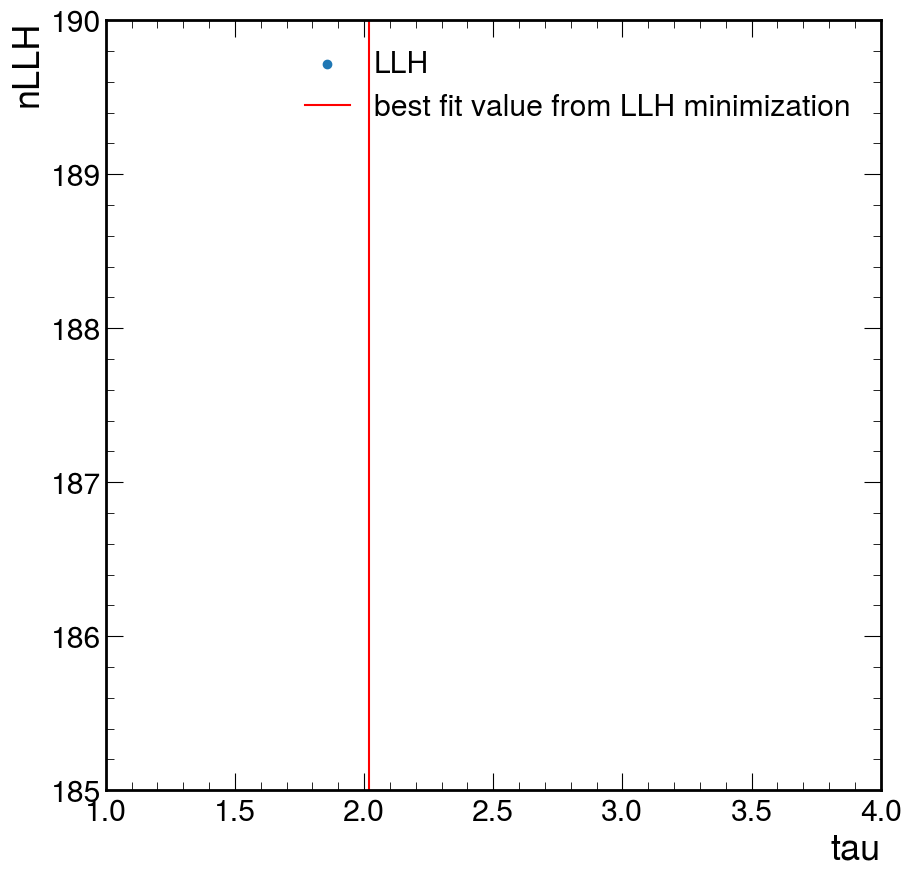